# Project - 2 - CSE 574 - Intro to Machine Learning
## Handwritten Digit Classification Using Neural Networks

**Team Members**
1. Vaibhav Bansal (vbansal6)
2. Devendra Rana (drana2)


In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
from numpy import exp
import time
import pickle

In [2]:
def initializeWeights(n_in, n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
       
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""

    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W
def sigmoid(z):
    """# Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""
    
    sigmoid_result = 1 / (1 + (exp(-z)))

    return  sigmoid_result

In [3]:
def preprocess():
    """ Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set

     Some suggestions for preprocessing step:
     - feature selection"""

    mat = loadmat('basecode/mnist_all.mat')  # loads the MAT object as a Dictionary

    # Pick a reasonable size for validation data

    # ------------Initialize preprocess arrays----------------------#
    train_preprocess = np.zeros(shape=(50000, 784))
    validation_preprocess = np.zeros(shape=(10000, 784))
    test_preprocess = np.zeros(shape=(10000, 784))
    train_label_preprocess = np.zeros(shape=(50000,))
    validation_label_preprocess = np.zeros(shape=(10000,))
    test_label_preprocess = np.zeros(shape=(10000,))
    # ------------Initialize flag variables----------------------#
    train_len = 0
    validation_len = 0
    test_len = 0
    train_label_len = 0
    validation_label_len = 0
    # ------------Start to split the data set into 6 arrays-----------#
    for key in mat:
        # -----------when the set is training set--------------------#
        if "train" in key:
            label = key[-1]  # record the corresponding label
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)  # get the length of current training set
            tag_len = tup_len - 1000  # defines the number of examples which will be added into the training set

            # ---------------------adding data to training set-------------------------#
            train_preprocess[train_len:train_len + tag_len] = tup[tup_perm[1000:], :]
            train_len += tag_len

            train_label_preprocess[train_label_len:train_label_len + tag_len] = label
            train_label_len += tag_len

            # ---------------------adding data to validation set-------------------------#
            validation_preprocess[validation_len:validation_len + 1000] = tup[tup_perm[0:1000], :]
            validation_len += 1000

            validation_label_preprocess[validation_label_len:validation_label_len + 1000] = label
            validation_label_len += 1000

            # ---------------------adding data to test set-------------------------#
        elif "test" in key:
            label = key[-1]
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)
            test_label_preprocess[test_len:test_len + tup_len] = label
            test_preprocess[test_len:test_len + tup_len] = tup[tup_perm]
            test_len += tup_len
            # ---------------------Shuffle,double and normalize-------------------------#
    train_size = range(train_preprocess.shape[0])
    train_perm = np.random.permutation(train_size)
    train_data = train_preprocess[train_perm]
    train_data = np.double(train_data)
    train_data = train_data / 255.0
    train_label = train_label_preprocess[train_perm]

    validation_size = range(validation_preprocess.shape[0])
    vali_perm = np.random.permutation(validation_size)
    validation_data = validation_preprocess[vali_perm]
    validation_data = np.double(validation_data)
    validation_data = validation_data / 255.0
    validation_label = validation_label_preprocess[vali_perm]

    test_size = range(test_preprocess.shape[0])
    test_perm = np.random.permutation(test_size)
    test_data = test_preprocess[test_perm]
    test_data = np.double(test_data)
    test_data = test_data / 255.0
    test_label = test_label_preprocess[test_perm]

    # Feature selection
    total_data=np.array(np.vstack((train_data, validation_data, test_data)))
    duplicates = np.all(total_data == total_data[0,:], axis = 0)
    sel_features = np.where(duplicates==False)
    total_data = total_data[:,~duplicates]
    
    # Collecting selected feature indices
    selected_features = np.array([])
    selected_features = sel_features[0]
        
    train_data = total_data[0:len(train_data),:]
    validation_data = total_data[len(train_data): (len(train_data) + len(validation_data)),:]
    test_data = total_data[(len(train_data) + len(validation_data)): (len(train_data) + len(validation_data) + len(test_data)),:]

    print('preprocess done')

    return train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features

In [4]:
def nnObjFunction(params, *args):
    """% nnObjFunction computes the value of objective function (negative log 
    %   likelihood error function with regularization) given the parameters 
    %   of Neural Networks, thetraining data, their corresponding training 
    %   labels and lambda - regularization hyper-parameter.

    % Input:
    % params: vector of weights of 2 matrices w1 (weights of connections from
    %     input layer to hidden layer) and w2 (weights of connections from
    %     hidden layer to output layer) where all of the weights are contained
    %     in a single vector.
    % n_input: number of node in input layer (not include the bias node)
    % n_hidden: number of node in hidden layer (not include the bias node)
    % n_class: number of node in output layer (number of classes in
    %     classification problem
    % training_data: matrix of training data. Each row of this matrix
    %     represents the feature vector of a particular image
    % training_label: the vector of truth label of training images. Each entry
    %     in the vector represents the truth label of its corresponding image.
    % lambda: regularization hyper-parameter. This value is used for fixing the
    %     overfitting problem.
       
    % Output: 
    % obj_val: a scalar value representing value of error function
    % obj_grad: a SINGLE vector of gradient value of error function
    % NOTE: how to compute obj_grad
    % Use backpropagation algorithm to compute the gradient of error function
    % for each weights in weight matrices.

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % reshape 'params' vector into 2 matrices of weight w1 and w2
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input 
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden 
    %     layer to unit i in output layer."""

    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    obj_val = 0

    # Your code here
    n = train_data.shape[0]
    # Feed forward code
    w1_transpose = np.transpose(w1)
    w2_transpose = np.transpose(w2)

    input_bias = np.ones(shape=(n, 1), dtype = np.float64) # create input bias 
    biased_training_data = np.append(train_data, input_bias, axis=1) # Add input bias to training data
    
    aj = np.dot(biased_training_data, w1_transpose) # Product of W and input data
    zj = sigmoid(aj) # Sigmoid of dot product
    
    hidden_bias = np.ones(shape=(zj.shape[0], 1), dtype = np.float64) 
    biased_zj = np.append(zj, hidden_bias, axis=1)
    
    bl = np.dot(biased_zj, w2_transpose)
    ol = sigmoid(bl)
    
    # Labelling output
    yl = np.zeros(shape=(n, 10), dtype = np.float64) # setting all output values to 0 initially
        
    for i in range(yl.shape[0]):   
        for j in range(yl.shape[1]):
            if j==training_label[i]:
                yl[i][j] = 1.0            
    
    # Error function
    
    p = yl*np.log(ol) 
    q = (1-yl)*np.log(1-ol)
    sum1 = np.sum(p + q)
    constant = -1*n
    error = sum1/constant # -(yl*log(ol)+(1-y1)*log(1-ol))/n
    
    # Regularised error function  
    
    w1_square_sum = np.sum(np.square(w1))
    w2_square_sum = np.sum(np.square(w2))
    sum2 = w1_square_sum + w2_square_sum                
    reg_factor = (sum2*lambdaval)/(2*n)
    reg_error = error + reg_factor
    
    obj_val = reg_error # Regularised error w.r.t lambda
    
    


    # Make sure you reshape the gradient matrices to a 1D array. for instance if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    # obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)
    obj_grad = np.array([])

    delta_l = ol-yl
    delta_l_transpose = np.transpose(delta_l)
    
    grad_w2 = np.dot(delta_l_transpose, biased_zj)
    
    r = (1-biased_zj[:,0:n_hidden])*biased_zj[:,0:n_hidden]
    s = np.dot(delta_l, w2[:,0:n_hidden])
    rs = r*s
    rs_transpose = np.transpose(rs)
    grad_w1 = np.dot(rs_transpose, biased_training_data)
    
    # Regularised gradients
    
    reg_grad_w2 = (grad_w2 + (lambdaval*w2))/n
    reg_grad_w1 = (grad_w1 + lambdaval*w1)/n
    obj_grad = np.concatenate((reg_grad_w1.flatten(), reg_grad_w2.flatten()),0)
    
    return (obj_val, obj_grad)


In [5]:
def nnPredict(w1, w2, data):
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % data: matrix of data. Each row of this matrix represents the feature 
    %       vector of a particular image
       
    % Output: 
    % label: a column vector of predicted labels"""

    labels = np.zeros(shape=(data.shape[0], 1))
    #labels = np.zeros((data.shape[0],1))

    # Feed forward code
    input_bias = np.ones(shape=(data.shape[0],1), dtype=np.float64)
    biased_data = np.append(data, input_bias, axis=1)
    
    w1_transpose = np.transpose(w1)
    w2_transpose = np.transpose(w2)
    
    aj = np.dot(biased_data, w1_transpose)
    zj = sigmoid(aj)
    
    hidden_bias = np.ones(shape=(zj.shape[0], 1), dtype=np.float64)
    biased_zj = np.append(zj, hidden_bias, axis=1)
    
    bl= np.dot(biased_zj, w2_transpose)
    ol = sigmoid(bl)
    
    for x in range(ol.shape[0]): # Label prediction
        max_arg = np.argmax(ol[x])
        labels[x] = max_arg
        
    return labels

In [6]:
train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features = preprocess()

#  Train Neural Network

# set the number of nodes in input unit (not including bias unit)
n_input = train_data.shape[1]

# set the number of nodes in hidden unit (not including bias unit)
n_hidden = 20

# set the number of nodes in output unit
n_class = 10

lambdaval = 11

t1 = time.time()


# initialize the weights into some random matrices
initial_w1 = initializeWeights(n_input, n_hidden)
initial_w2 = initializeWeights(n_hidden, n_class)

# unroll 2 weight matrices into single column vector
initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

# set the regularization hyper-parameter

args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

# Train Neural Network using fmin_cg or minimize from scipy,optimize module. Check documentation for a working example

opts = {'maxiter': 50}  # Preferred value.

nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)

# In Case you want to use fmin_cg, you may have to split the nnObjectFunction to two functions nnObjFunctionVal
# and nnObjGradient. Check documentation for this function before you proceed.
# nn_params, cost = fmin_cg(nnObjFunctionVal, initialWeights, nnObjGradient,args = args, maxiter = 50)


# Reshape nnParams from 1D vector into w1 and w2 matrices
w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

# Test the computed parameters

predicted_label = nnPredict(w1, w2, train_data)

print("\n Weight vector w1:"+str(w1))
print("\n Weight vector w2:"+str(w2))

# find the accuracy on Training Dataset

print('\n lambda:'+str(lambdaval)+'\n hidden layers:'+str(n_hidden))

print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label.reshape(train_label.shape[0], 1)).astype(float))) + '%')

predicted_label = nnPredict(w1, w2, validation_data)

# find the accuracy on Validation Dataset

print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label.reshape(validation_label.shape[0], 1)).astype(float))) + '%')

predicted_label = nnPredict(w1, w2, test_data)

# find the accuracy on Validation Dataset

print('\n Test set Accuracy:' + str(100 * np.mean((predicted_label == test_label.reshape(test_label.shape[0], 1)).astype(float))) + '%')

t2 = time.time()

print('\n Time taken:'+str(t2-t1))

# create params.picke file to store the following variables

store_obj = dict([("selected_features", selected_features),("w1",w1), ("w2",w2), ("n_hidden",n_hidden), ("lambdaval", lambdaval)])
pickle.dump(store_obj, open('params.pickle','wb'), protocol=3)


preprocess done

 Weight vector w1:[[-0.05490072  0.01288851 -0.06075502 ...  0.03860868  0.02681113
  -0.54161145]
 [ 0.03645891 -0.01010024 -0.0058741  ...  0.03885979  0.05563582
   0.07794359]
 [-0.05791962 -0.03863993  0.04961903 ... -0.01062185  0.01863874
  -0.48468843]
 ...
 [ 0.00880832 -0.05172222  0.0633665  ...  0.01796275 -0.02061929
  -0.34072193]
 [-0.00417715 -0.00465396  0.03478463 ...  0.01439848 -0.02117623
   0.02576118]
 [ 0.06490264  0.01661818  0.05914098 ... -0.05769445  0.0441083
   0.38530984]]

 Weight vector w2:[[-0.372172   -1.98420912  1.11079907 -2.74709216 -1.93134961  0.52674024
  -0.95702085  1.87241132 -1.3432554  -1.96357711  0.7271018   0.82955212
  -1.52421952 -2.17129852  2.21308958  0.66695828 -1.07478761  0.83631501
  -0.66874169 -2.19309737 -1.07938415]
 [-0.08043282  0.08916759 -3.54029392  1.26230487  1.96470536  1.23626931
   3.11623577 -0.48591559 -1.5117587   0.28147357 -1.08536891 -2.46462445
  -2.07605176  0.82231852 -0.69496843 -2.18199

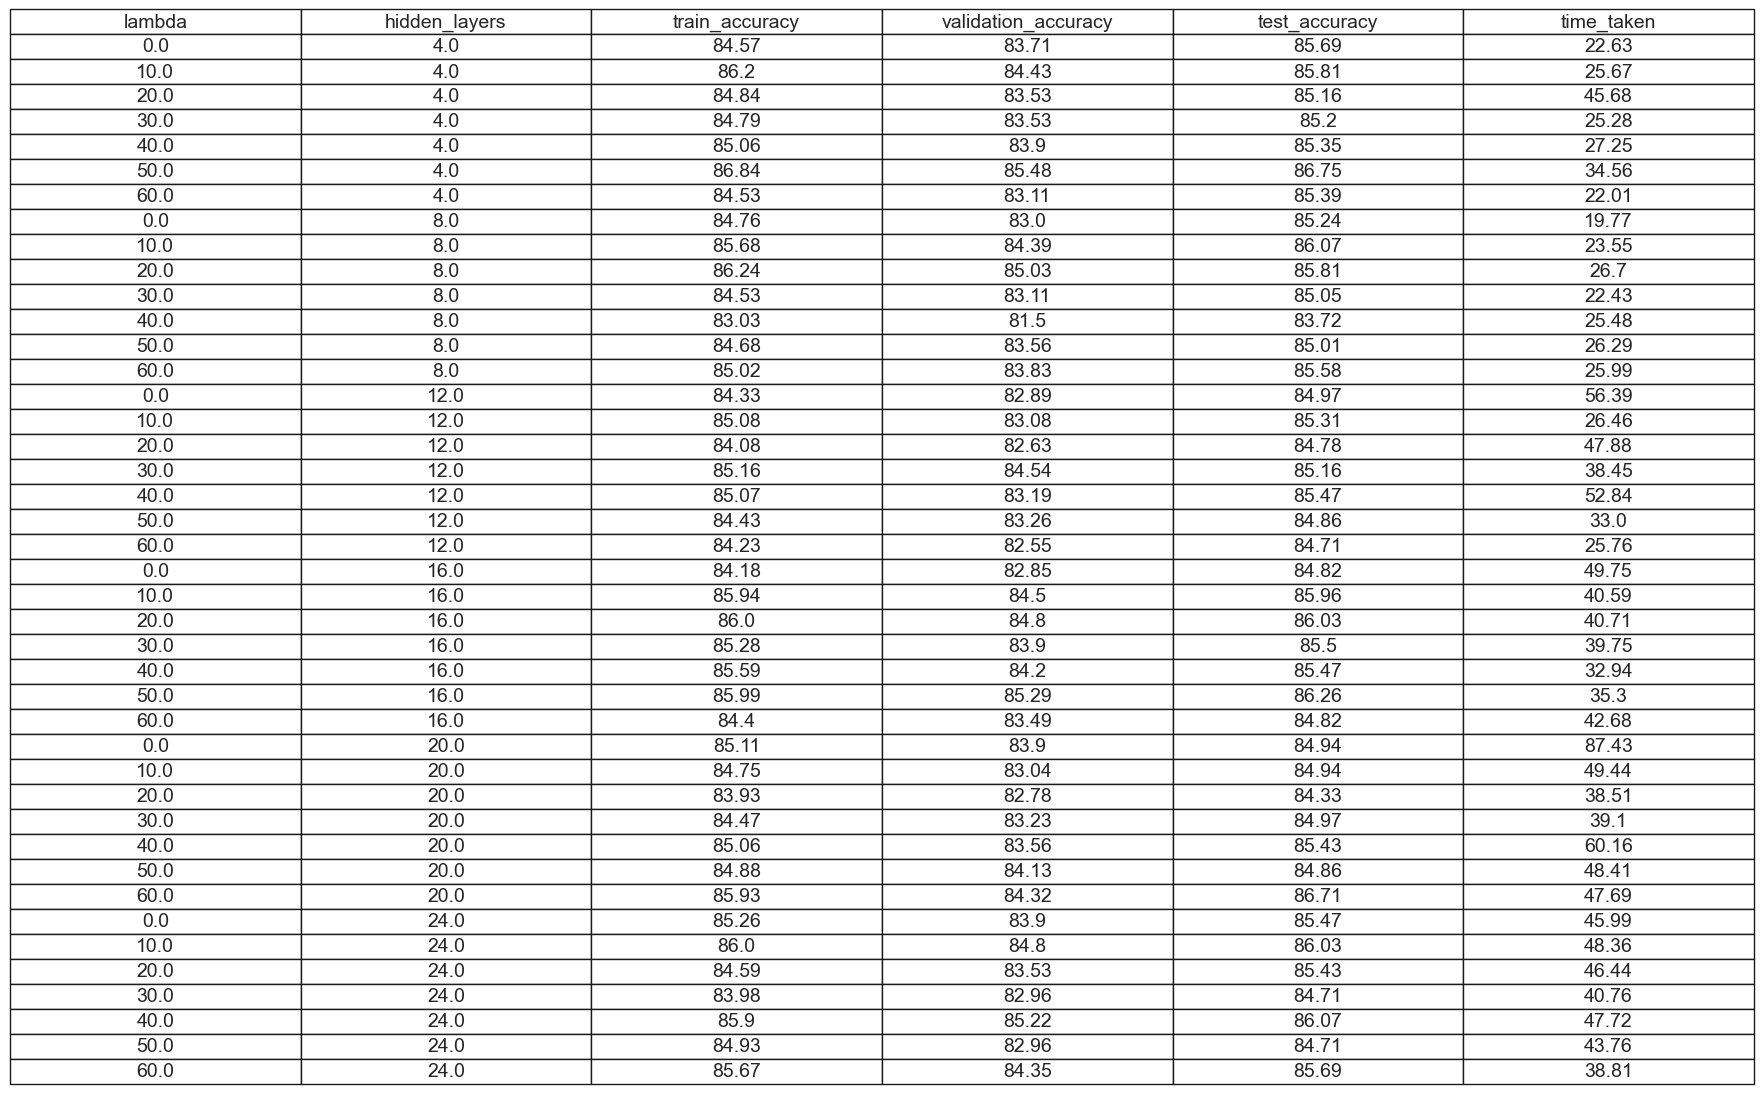

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for hyperparameters
data = {
    'lambda': [
        0, 10, 20, 30, 40, 50, 60, 0, 10, 20, 30, 40, 50, 60, 0, 10, 20, 30, 40, 50, 60,
        0, 10, 20, 30, 40, 50, 60, 0, 10, 20, 30, 40, 50, 60, 0, 10, 20, 30, 40, 50, 60
    ],
    'hidden_layers': [
        4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12,
        16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 20, 20, 20, 24, 24, 24, 24, 24, 24, 24
    ],
    'train_accuracy': [
        84.57, 86.20, 84.84, 84.79, 85.06, 86.84, 84.53, 84.76, 85.68, 86.24, 84.53, 83.03, 84.68, 85.02,
        84.33, 85.08, 84.08, 85.16, 85.07, 84.43, 84.23, 84.18, 85.94, 86.00, 85.28, 85.59, 85.99, 84.40,
        85.11, 84.75, 83.93, 84.47, 85.06, 84.88, 85.93, 85.26, 86.00, 84.59, 83.98, 85.90, 84.93, 85.67
    ],
    'validation_accuracy': [
        83.71, 84.43, 83.53, 83.53, 83.90, 85.48, 83.11, 83.00, 84.39, 85.03, 83.11, 81.50, 83.56, 83.83,
        82.89, 83.08, 82.63, 84.54, 83.19, 83.26, 82.55, 82.85, 84.50, 84.80, 83.90, 84.20, 85.29, 83.49,
        83.90, 83.04, 82.78, 83.23, 83.56, 84.13, 84.32, 83.90, 84.80, 83.53, 82.96, 85.22, 82.96, 84.35
    ],
    'test_accuracy': [
        85.69, 85.81, 85.16, 85.20, 85.35, 86.75, 85.39, 85.24, 86.07, 85.81, 85.05, 83.72, 85.01, 85.58,
        84.97, 85.31, 84.78, 85.16, 85.47, 84.86, 84.71, 84.82, 85.96, 86.03, 85.50, 85.47, 86.26, 84.82,
        84.94, 84.94, 84.33, 84.97, 85.43, 84.86, 86.71, 85.47, 86.03, 85.43, 84.71, 86.07, 84.71, 85.69
    ],
    'time_taken': [
        22.63, 25.67, 45.68, 25.28, 27.25, 34.56, 22.01, 19.77, 23.55, 26.70, 22.43, 25.48, 26.29, 25.99,
        56.39, 26.46, 47.88, 38.45, 52.84, 33.00, 25.76, 49.75, 40.59, 40.71, 39.75, 32.94, 35.30, 42.68,
        87.43, 49.44, 38.51, 39.10, 60.16, 48.41, 47.69, 45.99, 48.36, 46.44, 40.76, 47.72, 43.76, 38.81
    ]
}

# Convert to DataFrame
df_results = pd.DataFrame(data)

# Set optimal parameters (lambda = 10, hidden layers = 28)
optimal_lambda = 10
optimal_hidden_layers = 28

# Highlight the optimal parameters row
def highlight_optimal(row):
    if row['lambda'] == optimal_lambda and row['hidden_layers'] == optimal_hidden_layers:
        return ['background-color: yellow'] * len(row)
    else:
        return [''] * len(row)

# Plot the table with highlighting
plt.figure(figsize=(15, 8))
sns.set(font_scale=1.1)
table = plt.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')

# Apply highlighting by setting colors manually for optimal row
for i, row in df_results.iterrows():
    if row['lambda'] == optimal_lambda and row['hidden_layers'] == optimal_hidden_layers:
        for j in range(len(row)):
            table[(i + 1, j)].set_facecolor("yellow")

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)
plt.axis('off')
plt.show()
